In [1]:
import mesa
import math
import numpy as np
import matplotlib.pyplot as plt

from Model_Ilya_Play_Area import *

### Trying new features of the model

#### Simulate single population

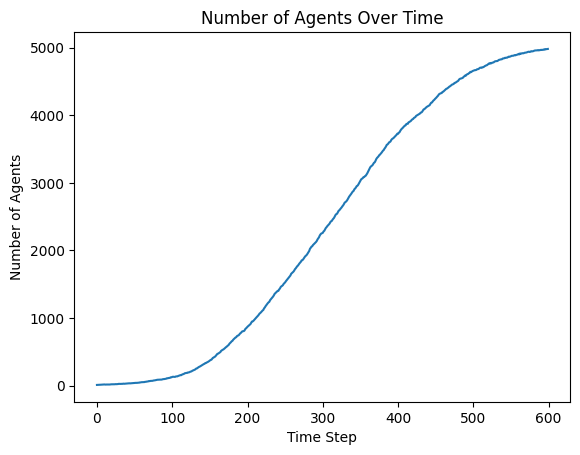

In [6]:
#Making x steps with in the model
x = 600

model = Microbiome(0,10, False, 50, 50, immediate_killing = False)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents = agent_num_data.loc[:,"Type_a_2"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents)

# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

In [10]:
# Reproduce in its own cell
# Look to accomodate x bacteria in neighbouring cells (start with 1)
# Iteratively increase radius of the search
# Keep track of the cells that have been already checked

In [5]:
pos_contents = model.grid.get_cell_list_contents((25,25))
pos_contents_bacteria = [c for c in pos_contents if not isinstance(c, Soil)]
num_bacteria = len(pos_contents_bacteria)
num_bacteria

0

#### Simulate both populations

In [ ]:
#Making x steps with in the model
x = 400

model = Microbiome(15, 50, False, 50, 50, immediate_killing = False)
for i in range(x):
    model.step()

# Check the numbers of agents

agent_num_data = model.datacollector.get_model_vars_dataframe()
num_of_agents_1 = agent_num_data.loc[:,"Type_a_1"]
num_of_agents_2 = agent_num_data.loc[:,"Type_a_2"]
number_of_time_steps = agent_num_data.index

# Plotting the number of agents over time
plt.plot(number_of_time_steps, num_of_agents_1, label = "Predator")
plt.plot(number_of_time_steps, num_of_agents_2, label = "Prey")

# Adding labels and title
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Number of Agents')
plt.title('Number of Agents Over Time')

# Displaying the plot
plt.show()

In [ ]:
s_mutens_radius = 0.75 # micrometers
average_bacteria_area = 4*math.pi*s_mutens_radius**2 

In [ ]:
# Extract the data about mass of one of the bacteria
my_variable_view = []

my_agents = [agent for agent in model.schedule.agents if isinstance(agent, Type_a_1)]
for agent in my_agents:

    my_vars = []
     
    # Acess the variables of the current agent
    my_variable_view.append(agent.area)
    # my_vars.append(agent.split_mass)
    # my_vars.append(agent.min_mass)
    #my_vars.append(agent.energy_netto)
    # my_vars.append(agent.max_viability_time)
    # my_vars.append(agent.viability_index)

    #my_variable_view.append(float(agent.energy_netto))

    #print(f"{agent.unique_id}:{my_vars}")
    # Print the unique ID and variable of the current agent
    # if agent.energy_netto > 1:
    #     print(f"{agent.unique_id}:{agent.energy_netto}")

# np.mean(my_variable_view)
# np.percentile(my_vars, 75)
my_variable_view


In [ ]:
# Unpack the list of np array floats into a list of floats

float_list = []
for array in my_variable_view:
    if not isinstance(array, int):
        float_list.append(array[0])
    else:
        float_list.append(array)

my_variable_view = float_list 

In [ ]:
plt.hist(my_variable_view, bins=100, edgecolor='black')

# Adding labels and title
plt.xlabel('My Variable Values')
plt.ylabel('Frequency')
plt.title('Histogram')

# Displaying the histogram
plt.show()